
The aim of the exercise is to get familiar with the histogram gradient-boosting in scikit-learn. Besides, we will use this model within a cross-validation framework in order to inspect internal parameters found via grid-search.

We will use the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

📝 TODO: First, create a histogram gradient boosting regressor. You can set the trees number to be large, and configure the model to use early-stopping.

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor

random_state = 42
regressor = HistGradientBoostingRegressor(
    random_state=random_state, max_iter=1000, early_stopping=True
)

📝 TODO: Use `RandomizedSearchCV` with `n_iter=20` to find the best set of
hyperparameters by tuning the following parameters of the `model`:
- max_depth: [3, 8];
- max_leaf_nodes: [15, 31];
- learning_rate: [0.1, 1].

Notice that in the notebook "Hyperparameter tuning by randomized-search" we
pass distributions to be sampled by the `RandomizedSearchCV`. In this case we
define a fixed grid of hyperparameters to be explored. Using a `GridSearchCV`
instead would explore all the possible combinations on the grid, which can be
costly to compute for large grids, whereas the parameter `n_iter` of the
`RandomizedSearchCV` controls the number of different random combination that
are evaluated. Notice that setting `n_iter` larger than the number of possible
combinations in a grid would lead to repeating
already-explored combinations. Here, this can't happen since the learning rate is sampled from a uniform so the number of possible combinations is infinite.

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_distributions = {
    "max_depth": randint(3, 8),
    "max_leaf_nodes": randint(15, 31),
    "learning_rate": uniform(0.1, 1),
}

model_random_search = RandomizedSearchCV(
    regressor,
    param_distributions=param_distributions,
    n_iter=10,
    n_jobs=2,
    random_state=random_state,
    cv=5,
    verbose=1,
)

📝 TODO: Finally, we will run our experiment through cross-validation. In this regard, define a 5-fold cross-validation. Besides, be sure to shuffle the data. Subsequently, use the function sklearn.model_selection.cross_validate to run the cross-validation. You should also set return_estimator=True, so that we can investigate the inner model trained via cross-validation.

In [4]:
from sklearn.model_selection import cross_validate, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
cross_val_results = cross_validate(
    model_random_search, data, target, cv=cv, return_estimator=True
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting 5 folds for each of 10 candidates, totalling 50 fits


📝 TODO: Now that we got the cross-validation results, print out the mean and standard deviation score.

In [5]:
cv_mean, cv_sd = (
    cross_val_results["test_score"].mean(),
    cross_val_results["test_score"].std(),
)
print(f"Mean score: {cv_mean:.3f} +/- {cv_sd:.3f}")

Mean score: 0.833 +/- 0.012


Then inspect the estimator entry of the results and check the best parameters values. Besides, check the number of trees used by the model.

In [6]:
for estimator in cross_val_results["estimator"]:
    print(estimator.best_params_)
    print("Number of trees:", estimator.best_estimator_.n_iter_)

{'learning_rate': np.float64(0.10706630521971741), 'max_depth': 3, 'max_leaf_nodes': 15}
Number of trees: 452
{'learning_rate': np.float64(0.10706630521971741), 'max_depth': 3, 'max_leaf_nodes': 15}
Number of trees: 514
{'learning_rate': np.float64(0.10706630521971741), 'max_depth': 3, 'max_leaf_nodes': 15}
Number of trees: 451
{'learning_rate': np.float64(0.15641157902710026), 'max_depth': 6, 'max_leaf_nodes': 28}
Number of trees: 204
{'learning_rate': np.float64(0.10706630521971741), 'max_depth': 3, 'max_leaf_nodes': 15}
Number of trees: 446


📝 TODO: Inspect the results of the inner CV for each estimator of the outer CV. Aggregate the mean test score for each parameter combination and make a box plot of these scores.

In [7]:
import pandas as pd

inner_cv_results = []
for cv_ix, estimator_ in enumerate(cross_val_results["estimator"]):
    results = pd.DataFrame(estimator_.cv_results_)
    results["param_learning_rate"] = results["param_learning_rate"].round(4)
    results = results.pivot_table(
        index=["param_max_depth", "param_max_leaf_nodes", "param_learning_rate"],
        values="mean_test_score",
    ).rename(columns={"mean_test_score": f"CV {cv_ix}"})
    inner_cv_results.append(results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

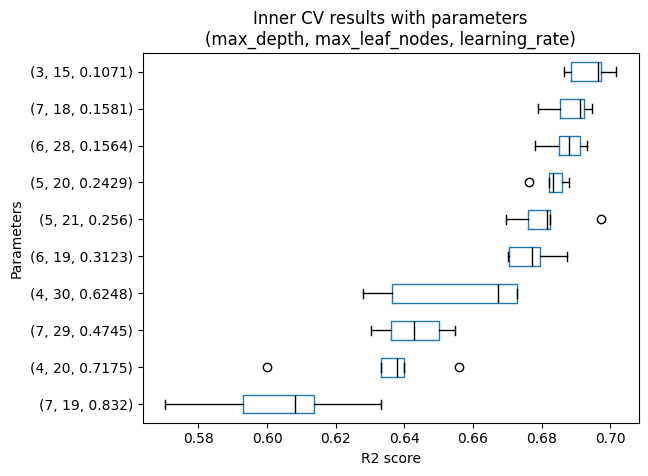

In [8]:
import matplotlib.pyplot as plt

# Sort the inner_cv_results by the mean of the columns
sorted_inner_cv_results = inner_cv_results.mean().sort_values().index
inner_cv_results = inner_cv_results[sorted_inner_cv_results]

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title(
    "Inner CV results with parameters\n" "(max_depth, max_leaf_nodes, learning_rate)"
)

We see that the first 4 ranked set of parameters are very close. We could select any of these 4 combinations. It coincides with the results we observe when inspecting the best parameters of the outer CV.